# This notebook will read in .txt files of betting odds for the last 7 years of NBA games, analyze them and prepare them for ML

In [599]:
import os
import pandas as pd
import numpy as np
import datetime
import re
import inspect


from sklearnex import patch_sklearn
patch_sklearn()

import sklearn
import optuna
import xgboost as xgb

import shap
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline

from itertools import chain
from pandas_profiling import ProfileReport
from boruta import BorutaPy
from imblearn.over_sampling import ADASYN
from functools import partial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import FeatureHasher

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    StackingClassifier
)

from sklearn.model_selection import (
    train_test_split,
    RepeatedKFold,
    cross_validate, 
    cross_val_score
)

from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder,
    PowerTransformer,
    MinMaxScaler
)

from sklearn.metrics import (
    accuracy_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    f1_score,
    cohen_kappa_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [600]:
files = [filename for filename in os.listdir('Data') if os.path.isdir(os.path.join('Data',filename))]
odds = []
scores = []
for file in files:
    temp_odds = pd.read_csv('Data/'+file+'/vegas.txt',index_col=0,parse_dates=True)
    temp_scores = pd.read_csv('Data/'+file+'/raw_scores.txt',index_col=0,parse_dates=True)
    odds.append(temp_odds)
    scores.append(temp_scores)
master_odds = pd.concat(odds,axis=0)
master_scores = pd.concat(scores,axis=0)

In [601]:
display(master_odds)
master_odds.index = pd.to_datetime(master_odds.index)

,Location,Team,OppTeam,TeamId,GameId,PercentBet_ML,Open_Line_ML,Pinnacle_ML,5dimes_ML,Heritage_ML,...,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Pts,Spread,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,away,Boston,Cleveland,1610612738,21700001,50.4,150.0,166.0,170.0,165.0,...,216.17,-106.83,216.5,216.0,-101.0,-110.0,99.0,-3.0,L,201.0
2017-10-17,home,Cleveland,Boston,1610612739,21700001,49.6,-170.0,-185.0,-185.0,-190.0,...,216.17,-108.17,216.5,216.0,-105.0,-110.0,102.0,3.0,W,201.0
2017-10-17,away,Houston,Golden State,1610612745,21700002,52.7,405.0,377.0,420.0,390.0,...,231.75,-109.67,235.0,230.5,-103.0,-115.0,122.0,1.0,W,243.0
2017-10-17,home,Golden State,Houston,1610612744,21700002,47.3,-500.0,-440.0,-475.0,-515.0,...,231.75,-105.33,235.0,230.5,-100.0,-110.0,121.0,-1.0,L,243.0
2017-10-18,away,Charlotte,Detroit,1610612766,21700003,51.3,130.0,127.0,130.0,125.0,...,202.17,-107.83,203.0,202.0,-102.0,-115.0,90.0,-12.0,L,192.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-13,home,L.A. Lakers,Utah,1610612747,21501228,95.0,195.0,153.0,150.0,145.0,...,195.08,-107.17,196.5,189.5,-103.0,-110.0,101.0,5.0,W,197.0
2016-04-13,away,L.A. Clippers,Phoenix,1610612746,21501229,65.3,175.0,166.0,170.0,180.0,...,205.33,-109.83,206.0,203.5,-105.0,-115.0,105.0,-9.0,L,219.0
2016-04-13,home,Phoenix,L.A. Clippers,1610612756,21501229,34.7,-205.0,-185.0,-200.0,-210.0,...,205.33,-106.83,206.0,203.5,-101.0,-110.0,114.0,9.0,W,219.0


In [602]:
master_scores.columns

Index(['GAME_SEQUENCE', 'GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION',
       'TEAM_CITY_NAME', 'TEAM_WINS_LOSSES', 'PTS_QTR1', 'PTS_QTR2',
       'PTS_QTR3', 'PTS_QTR4', 'PTS_OT1', 'PTS_OT2', 'PTS_OT3', 'PTS_OT4',
       'PTS_OT5', 'PTS_OT6', 'PTS_OT7', 'PTS_OT8', 'PTS_OT9', 'PTS_OT10',
       'PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'TOV'],
      dtype='object')

In [603]:
master_odds = master_odds[[
       'Location', 'Team', 'OppTeam', 'TeamId', 'GameId', 'PercentBet_OU', 'Open_Line_OU', 'Open_Odds_OU',
       'Pinnacle_Line_OU', 'Pinnacle_Odds_OU', '5dimes_Line_OU',
       '5dimes_Odds_OU', 'Heritage_Line_OU', 'Heritage_Odds_OU',
       'Bovada_Line_OU', 'Bovada_Odds_OU', 'Betonline_Line_OU',
       'Betonline_Odds_OU', 'Average_Line_OU', 'Average_Odds_OU',
       'Best_Line_OU', 'Worst_Line_OU', 'Best_Odds_OU', 'Worst_Odds_OU',
       'Result', 'Total'
    ]]

In [604]:
master_odds.dtypes

Location              object
Team                  object
OppTeam               object
TeamId                 int64
GameId                 int64
PercentBet_OU        float64
Open_Line_OU         float64
Open_Odds_OU         float64
Pinnacle_Line_OU     float64
Pinnacle_Odds_OU     float64
5dimes_Line_OU       float64
5dimes_Odds_OU       float64
Heritage_Line_OU     float64
Heritage_Odds_OU     float64
Bovada_Line_OU       float64
Bovada_Odds_OU       float64
Betonline_Line_OU    float64
Betonline_Odds_OU    float64
Average_Line_OU      float64
Average_Odds_OU      float64
Best_Line_OU         float64
Worst_Line_OU        float64
Best_Odds_OU         float64
Worst_Odds_OU        float64
Result                object
Total                float64
dtype: object

In [605]:
master_odds_away = master_odds[master_odds['Location'] == 'away']
master_odds_home = master_odds[master_odds['Location'] == 'home']
display(master_odds_away.head(20))
display(master_odds_home.head(20))

,Location,Team,OppTeam,TeamId,GameId,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,away,Boston,Cleveland,1610612738,21700001,47.0,216.5,-110.0,216.5,-101.0,...,216.0,-110.0,216.17,-106.83,216.5,216.0,-101.0,-110.0,L,201.0
2017-10-17,away,Houston,Golden State,1610612745,21700002,43.1,235.0,-110.0,230.5,-110.0,...,230.5,-115.0,231.75,-109.67,235.0,230.5,-103.0,-115.0,W,243.0
2017-10-18,away,Charlotte,Detroit,1610612766,21700003,42.9,203.0,-110.0,202.0,-105.0,...,202.0,-115.0,202.17,-107.83,203.0,202.0,-102.0,-115.0,L,192.0
2017-10-18,away,Brooklyn,Indiana,1610612751,21700004,0.0,212.5,-110.0,216.5,-110.0,...,217.0,-105.0,216.00,-108.00,217.0,212.5,-105.0,-110.0,L,271.0
2017-10-18,away,Miami,Orlando,1610612748,21700005,0.0,207.0,-110.0,205.5,-103.0,...,205.5,-110.0,205.67,-108.33,207.0,205.0,-103.0,-115.0,L,225.0
2017-10-18,away,Philadelphia,Washington,1610612755,21700006,62.1,215.0,-110.0,218.0,-104.0,...,217.5,-115.0,217.42,-107.83,218.0,215.0,-103.0,-115.0,L,235.0
2017-10-18,away,Milwaukee,Boston,1610612749,21700007,58.6,209.5,-110.0,203.5,-103.0,...,204.0,-100.0,204.50,-105.17,209.5,203.0,-100.0,-110.0,W,208.0
2017-10-18,away,New Orleans,Memphis,1610612740,21700008,0.0,204.0,-110.0,204.5,-104.0,...,204.5,-110.0,204.42,-108.17,205.0,204.0,-104.0,-115.0,L,194.0
2017-10-18,away,Atlanta,Dallas,1610612737,21700009,8.3,200.0,-110.0,198.5,-109.0,...,199.0,-110.0,199.08,-107.67,200.0,198.5,-102.0,-110.0,W,228.0


,Location,Team,OppTeam,TeamId,GameId,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,Result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,home,Cleveland,Boston,1610612739,21700001,53.0,216.5,-110.0,216.5,-109.0,...,216.0,-110.0,216.17,-108.17,216.5,216.0,-105.0,-110.0,W,201.0
2017-10-17,home,Golden State,Houston,1610612744,21700002,56.9,235.0,-110.0,230.5,-100.0,...,230.5,-105.0,231.75,-105.33,235.0,230.5,-100.0,-110.0,L,243.0
2017-10-18,home,Detroit,Charlotte,1610612765,21700003,57.1,203.0,-110.0,202.0,-105.0,...,202.0,-105.0,202.17,-107.17,203.0,202.0,-105.0,-110.0,W,192.0
2017-10-18,home,Indiana,Brooklyn,1610612754,21700004,100.0,212.5,-110.0,216.5,-100.0,...,217.0,-115.0,216.00,-107.00,217.0,212.5,-100.0,-115.0,W,271.0
2017-10-18,home,Orlando,Miami,1610612753,21700005,100.0,207.0,-110.0,205.5,-107.0,...,205.5,-110.0,205.67,-106.67,207.0,205.0,-103.0,-110.0,W,225.0
2017-10-18,home,Washington,Philadelphia,1610612764,21700006,37.9,215.0,-110.0,218.0,-106.0,...,217.5,-105.0,217.42,-107.17,218.0,215.0,-105.0,-110.0,W,235.0
2017-10-18,home,Boston,Milwaukee,1610612738,21700007,41.4,209.5,-110.0,203.5,-107.0,...,204.0,-120.0,204.50,-109.83,209.5,203.0,-102.0,-120.0,L,208.0
2017-10-18,home,Memphis,New Orleans,1610612763,21700008,100.0,204.0,-110.0,204.5,-106.0,...,204.5,-110.0,204.42,-106.83,205.0,204.0,-105.0,-110.0,W,194.0
2017-10-18,home,Dallas,Atlanta,1610612742,21700009,91.7,200.0,-110.0,198.5,-101.0,...,199.0,-110.0,199.08,-107.33,200.0,198.5,-101.0,-110.0,L,228.0


In [606]:
team_name_dict = {}
team_name_dict1 = master_odds_away.set_index('TeamId').to_dict()['Team']
for key,value in team_name_dict1.items():
    if value not in team_name_dict.values():
        team_name_dict[key] = value
team_name_dict = {y: x for x, y in team_name_dict.items()}


In [607]:
team_name_dict

{'Boston': 1610612738,
 'Houston': 1610612745,
 'Charlotte': 1610612766,
 'Brooklyn': 1610612751,
 'Miami': 1610612748,
 'Philadelphia': 1610612755,
 'Milwaukee': 1610612749,
 'New Orleans': 1610612740,
 'Atlanta': 1610612737,
 'Denver': 1610612743,
 'Minnesota': 1610612750,
 'Portland': 1610612757,
 'Chicago': 1610612741,
 'New York': 1610612752,
 'L.A. Clippers': 1610612746,
 'Detroit': 1610612765,
 'Cleveland': 1610612739,
 'Orlando': 1610612753,
 'Utah': 1610612762,
 'Sacramento': 1610612758,
 'Golden State': 1610612744,
 'L.A. Lakers': 1610612747,
 'Indiana': 1610612754,
 'San Antonio': 1610612759,
 'Dallas': 1610612742,
 'Oklahoma City': 1610612760,
 'Phoenix': 1610612756,
 'Memphis': 1610612763,
 'Toronto': 1610612761,
 'Washington': 1610612764}

In [608]:
master_odds_home.drop(columns=['Location', 'Team'], inplace=True)
master_odds_home =  master_odds_home.rename(columns={
    'OppTeam': 'away_team_id',
    'TeamId' : 'home_team_id',
    'Result' : 'home_team_result',
    'GameId' : 'game_id'

})


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [609]:
master_odds_home1 = master_odds_home.replace({'away_team_id': team_name_dict})
master_odds_home1['away_team_id'] = master_odds_home1['away_team_id'].astype('int64')
master_odds_home1['home_team_result'].replace({
    'W' : 1,
    'L' : 0
},inplace=True)


In [610]:
display(master_odds_home1)

,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,home_team_result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-10-17,1610612738,1610612739,21700001,53.0,216.5,-110.0,216.5,-109.0,216.0,-105.0,...,216.0,-110.0,216.17,-108.17,216.5,216.0,-105.0,-110.0,1,201.0
2017-10-17,1610612745,1610612744,21700002,56.9,235.0,-110.0,230.5,-100.0,231.0,-107.0,...,230.5,-105.0,231.75,-105.33,235.0,230.5,-100.0,-110.0,0,243.0
2017-10-18,1610612766,1610612765,21700003,57.1,203.0,-110.0,202.0,-105.0,202.0,-108.0,...,202.0,-105.0,202.17,-107.17,203.0,202.0,-105.0,-110.0,1,192.0
2017-10-18,1610612751,1610612754,21700004,100.0,212.5,-110.0,216.5,-100.0,216.5,-102.0,...,217.0,-115.0,216.00,-107.00,217.0,212.5,-100.0,-115.0,1,271.0
2017-10-18,1610612748,1610612753,21700005,100.0,207.0,-110.0,205.5,-107.0,205.5,-103.0,...,205.5,-110.0,205.67,-106.67,207.0,205.0,-103.0,-110.0,1,225.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-04-13,1610612740,1610612750,21501226,41.6,213.0,-110.0,212.0,-100.0,212.5,-110.0,...,212.5,-110.0,212.67,-107.50,213.0,212.0,-100.0,-110.0,1,253.0
2016-04-13,1610612763,1610612744,21501227,56.6,211.5,-110.0,213.5,-105.0,213.0,-110.0,...,213.0,-110.0,213.08,-109.17,214.0,211.5,-105.0,-115.0,1,229.0
2016-04-13,1610612762,1610612747,21501228,38.8,189.5,-110.0,196.0,-103.0,196.0,-110.0,...,196.5,-110.0,195.08,-107.17,196.5,189.5,-103.0,-110.0,1,197.0


In [611]:
master_odds_home1.dtypes

away_team_id           int64
home_team_id           int64
game_id                int64
PercentBet_OU        float64
Open_Line_OU         float64
Open_Odds_OU         float64
Pinnacle_Line_OU     float64
Pinnacle_Odds_OU     float64
5dimes_Line_OU       float64
5dimes_Odds_OU       float64
Heritage_Line_OU     float64
Heritage_Odds_OU     float64
Bovada_Line_OU       float64
Bovada_Odds_OU       float64
Betonline_Line_OU    float64
Betonline_Odds_OU    float64
Average_Line_OU      float64
Average_Odds_OU      float64
Best_Line_OU         float64
Worst_Line_OU        float64
Best_Odds_OU         float64
Worst_Odds_OU        float64
home_team_result       int64
Total                float64
dtype: object

Text(0, 0.5, 'Total Points scored')

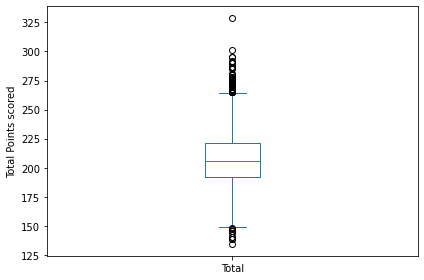

In [612]:
ax = (master_odds_home1['Total'].plot.box())
ax.set_ylabel('Total Points scored')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Total)')

Text(0, 0.5, 'Average Line O/U')

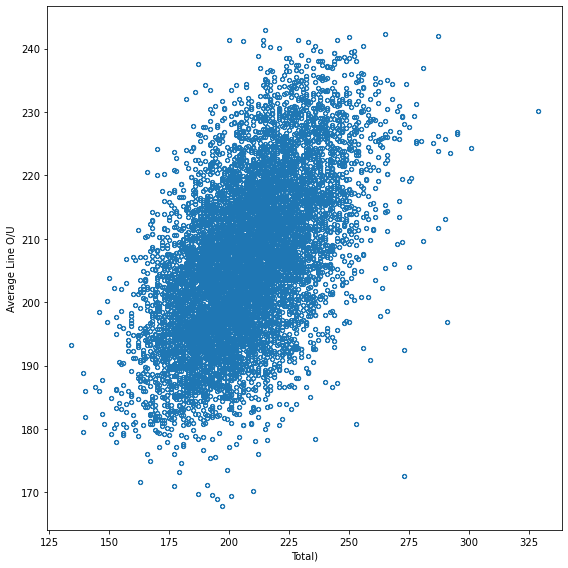

In [613]:
ax = master_odds_home1.plot.scatter(x='Total', y='Average_Line_OU', figsize=(8, 8), marker='$\u25EF$')
ax.set_xlabel('Total)')
ax.set_ylabel('Average Line O/U')

plt.tight_layout()
plt.show()

Text(0.5, 0, 'Total Points Scored')

Text(0, 0.5, 'Average Line O/U')

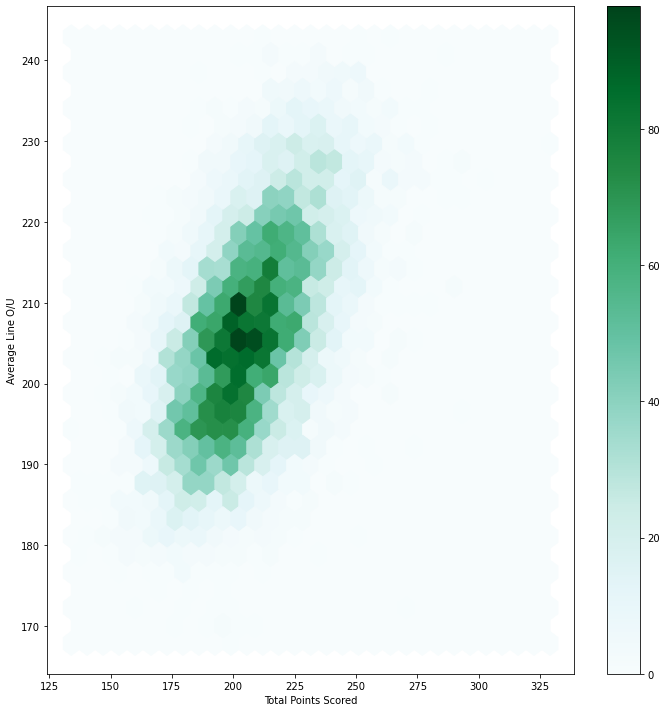

In [614]:
ax = master_odds_home1.plot.hexbin(x='Total', y='Average_Line_OU',
                         gridsize=30, sharex=False, figsize=(10,10))
ax.set_xlabel('Total Points Scored')
ax.set_ylabel('Average Line O/U')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Total', ylabel='Average_Line_OU'>

Text(0.5, 0, 'Total Points Scored')

Text(0, 0.5, 'Average O/U Line')

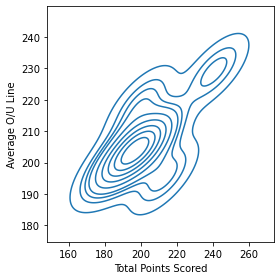

In [615]:
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(data=master_odds_home1.sample(10), x='Total', y='Average_Line_OU', ax=ax)
ax.set_xlabel('Total Points Scored')
ax.set_ylabel('Average O/U Line')

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='Total', ylabel='Count'>

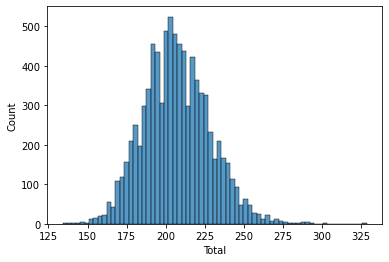

In [616]:
sns.histplot(master_odds_home1.Total)

<AxesSubplot:xlabel='Total', ylabel='Count'>

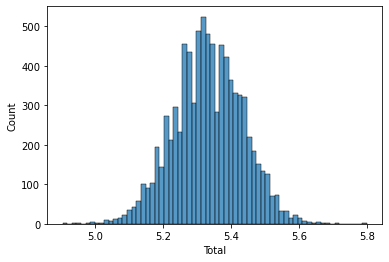

In [617]:
log_price = np.log1p(master_odds_home1.Total)
sns.histplot(log_price)

In [618]:
master_odds_home1.isnull().sum()

away_team_id           0
home_team_id           0
game_id                0
PercentBet_OU          0
Open_Line_OU          87
Open_Odds_OU          87
Pinnacle_Line_OU      39
Pinnacle_Odds_OU      39
5dimes_Line_OU        55
5dimes_Odds_OU        55
Heritage_Line_OU      77
Heritage_Odds_OU      77
Bovada_Line_OU       140
Bovada_Odds_OU       140
Betonline_Line_OU     41
Betonline_Odds_OU     41
Average_Line_OU        1
Average_Odds_OU        1
Best_Line_OU           1
Worst_Line_OU          1
Best_Odds_OU           1
Worst_Odds_OU          1
home_team_result       0
Total                  0
dtype: int64

# Linear Regression 

In [619]:
n = len(master_odds_home1)

n_val = int(0.1 * n)
n_test = int(0.1 * n)
n_train = n - (n_val + n_test)

np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = master_odds_home1.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [620]:
df_train
df_val
df_test

,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,home_team_result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-05,1610612760,1610612757,21700144,37.8,208.0,-110.0,212.0,-104.0,212.0,-107.0,...,211.0,-105.0,211.17,-106.83,212.0,208.0,-104.0,-110.0,1,202.0
2014-12-09,1610612748,1610612756,21400313,46.0,203.5,-110.0,202.5,-110.0,202.5,-105.0,...,202.5,-110.0,202.75,-108.83,203.5,202.5,-105.0,-110.0,0,200.0
2013-02-24,1610612758,1610612740,21200834,43.5,200.5,-110.0,204.5,-102.0,204.5,-110.0,...,204.5,-110.0,204.00,-109.50,205.0,200.5,-102.0,-115.0,1,205.0
2014-04-02,1610612749,1610612748,21301121,100.0,195.0,-110.0,194.0,-105.0,194.0,-105.0,...,194.5,-110.0,194.42,-109.17,195.0,194.0,-105.0,-115.0,1,173.0
2015-03-15,1610612737,1610612747,21400989,58.0,197.5,-110.0,194.5,-100.0,194.5,-103.0,...,195.0,-110.0,195.17,-106.00,197.5,194.5,-100.0,-110.0,0,177.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-25,1610612755,1610612762,21201052,62.2,194.0,-110.0,191.0,-105.0,191.0,-102.0,...,191.0,-110.0,191.75,-107.83,194.0,191.0,-102.0,-110.0,1,198.0
2018-01-20,1610612748,1610612766,21700676,35.3,205.5,-110.0,201.5,-106.0,201.0,-103.0,...,201.0,-105.0,201.67,-106.50,205.5,200.0,-103.0,-110.0,0,211.0
2018-02-09,1610612757,1610612758,21700825,52.1,208.5,-110.0,206.0,-105.0,206.5,-101.0,...,206.5,-114.0,206.75,-108.33,208.5,206.0,-101.0,-115.0,0,218.0


,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,home_team_result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2016-11-23,1610612756,1610612753,21600214,48.1,206.5,-110.0,209.5,-105.0,209.5,-110.0,...,209.5,-110.0,209.08,-109.17,210.0,206.5,-105.0,-115.0,0,179.0
2015-12-06,1610612747,1610612765,21500301,91.3,199.0,-110.0,199.5,-105.0,199.5,-105.0,...,199.5,-110.0,199.25,-106.67,199.5,199.0,-105.0,-110.0,1,202.0
2012-12-10,1610612759,1610612745,21200301,41.6,210.0,-110.0,211.5,-111.0,212.0,-108.0,...,212.0,-110.0,211.42,-110.67,212.0,210.0,-108.0,-115.0,0,260.0
2019-03-10,1610612749,1610612759,21800999,42.1,NaN,NaN,229.0,-104.0,229.0,-105.0,...,229.5,-110.0,229.10,-105.80,229.5,229.0,-104.0,-110.0,1,235.0
2018-04-04,1610612738,1610612761,21701171,41.8,206.5,-110.0,204.0,-104.0,203.5,-103.0,...,203.5,-110.0,204.17,-106.17,206.5,203.5,-103.0,-110.0,1,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-01-16,1610612751,1610612764,21400590,49.1,192.0,-110.0,191.0,-105.0,191.0,-105.0,...,191.5,-110.0,191.58,-108.83,192.0,191.0,-105.0,-115.0,0,182.0
2016-03-27,1610612742,1610612758,21501095,50.5,217.0,-110.0,217.0,-105.0,217.0,-110.0,...,217.5,-110.0,217.08,-107.50,217.5,217.0,-105.0,-110.0,1,244.0
2018-03-28,1610612746,1610612756,21701122,49.3,223.0,-110.0,222.0,-102.0,222.0,-102.0,...,222.5,-110.0,222.33,-105.67,223.0,222.0,-102.0,-110.0,0,210.0


,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Betonline_Line_OU,Betonline_Odds_OU,Average_Line_OU,Average_Odds_OU,Best_Line_OU,Worst_Line_OU,Best_Odds_OU,Worst_Odds_OU,home_team_result,Total
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-01,1610612761,1610612738,21600732,91.7,217.5,-110.0,214.0,-101.0,214.0,-110.0,...,213.5,-105.0,214.67,-106.00,217.5,213.5,-101.0,-110.0,1,213.0
2017-01-08,1610612739,1610612756,21600565,46.1,222.0,-110.0,221.0,-102.0,221.0,-110.0,...,221.0,-110.0,221.42,-108.67,222.0,221.0,-102.0,-115.0,0,236.0
2019-03-13,1610612744,1610612745,21801018,46.8,230.5,-110.0,228.0,-105.0,228.0,-105.0,...,228.0,-110.0,228.58,-106.67,230.5,228.0,-105.0,-110.0,0,210.0
2014-11-09,1610612762,1610612765,21400091,93.8,195.0,-110.0,192.5,-105.0,192.0,-105.0,...,192.0,-110.0,192.58,-107.17,195.0,192.0,-105.0,-110.0,0,193.0
2018-02-15,1610612743,1610612749,21700865,44.0,210.5,-110.0,214.5,-100.0,214.5,-107.0,...,214.5,-105.0,214.00,-106.17,215.0,210.5,-100.0,-110.0,0,257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-25,1610612757,1610612760,21701100,41.2,212.0,-110.0,218.0,-105.0,218.0,-108.0,...,218.0,-109.0,217.00,-107.00,218.0,212.0,-105.0,-110.0,0,213.0
2018-10-24,1610612750,1610612761,21800055,43.4,226.0,-110.0,226.5,-109.0,227.0,-106.0,...,226.5,-110.0,226.50,-107.50,227.0,226.0,-105.0,-110.0,1,217.0
2013-01-05,1610612757,1610612750,21200494,100.0,192.5,-110.0,190.5,-105.0,190.5,-107.0,...,190.0,-115.0,190.67,-108.67,192.5,190.0,-105.0,-115.0,0,199.0


In [621]:
n_val
n_test
n_train

860

860

6884

In [622]:
y_train = df_train.Total.values
y_val = df_val.Total.values
y_test = df_test.Total.values


In [623]:
y_train
y_val
y_test

array([202., 200., 205., ..., 218., 204., 245.])

array([179., 202., 260., 235., 174., 209., 188., 215., 223., 244., 223.,
       205., 225., 210., 212., 194., 190., 198., 231., 177., 215., 201.,
       243., 198., 266., 206., 192., 225., 264., 203., 193., 193., 169.,
       243., 199., 188., 192., 225., 204., 239., 203., 226., 177., 219.,
       264., 193., 215., 215., 192., 173., 196., 240., 241., 237., 213.,
       198., 253., 186., 168., 234., 225., 198., 208., 228., 188., 199.,
       202., 181., 210., 147., 174., 190., 164., 199., 201., 241., 199.,
       227., 214., 139., 177., 219., 203., 183., 199., 189., 182., 158.,
       210., 186., 233., 202., 197., 188., 174., 213., 231., 229., 173.,
       222., 153., 203., 224., 240., 226., 163., 218., 196., 195., 213.,
       220., 214., 192., 207., 192., 175., 217., 175., 222., 202., 238.,
       202., 201., 192., 198., 180., 188., 222., 185., 198., 191., 196.,
       206., 266., 238., 187., 238., 218., 221., 253., 177., 243., 212.,
       242., 211., 192., 189., 215., 224., 221., 22

array([213., 236., 210., 193., 257., 166., 218., 216., 179., 206., 214.,
       161., 174., 199., 202., 204., 206., 180., 224., 206., 223., 237.,
       192., 196., 202., 204., 198., 196., 200., 227., 203., 193., 225.,
       202., 198., 219., 255., 175., 209., 231., 198., 205., 202., 199.,
       218., 204., 193., 182., 176., 170., 193., 195., 215., 247., 219.,
       190., 195., 182., 192., 206., 198., 183., 204., 174., 199., 235.,
       214., 222., 204., 217., 192., 202., 235., 200., 200., 160., 182.,
       205., 217., 229., 207., 194., 217., 196., 241., 192., 182., 170.,
       170., 191., 208., 188., 209., 202., 181., 232., 227., 245., 183.,
       231., 246., 191., 225., 234., 233., 194., 179., 198., 235., 194.,
       211., 209., 244., 224., 237., 196., 173., 214., 215., 209., 180.,
       165., 193., 205., 194., 186., 216., 170., 258., 199., 170., 185.,
       189., 190., 183., 196., 193., 200., 211., 179., 218., 186., 194.,
       229., 212., 192., 226., 184., 193., 240., 21

In [624]:
del df_train['Total']
del df_val['Total']
del df_test['Total']

In [625]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

In [626]:
df_train = df_train.fillna(0)
df_val = df_val.fillna(0)
df_test = df_test.fillna(0)

In [627]:
df_train.columns

Index(['away_team_id', 'home_team_id', 'game_id', 'PercentBet_OU',
       'Open_Line_OU', 'Open_Odds_OU', 'Pinnacle_Line_OU', 'Pinnacle_Odds_OU',
       '5dimes_Line_OU', '5dimes_Odds_OU', 'Heritage_Line_OU',
       'Heritage_Odds_OU', 'Bovada_Line_OU', 'Bovada_Odds_OU',
       'Betonline_Line_OU', 'Betonline_Odds_OU', 'Average_Line_OU',
       'Average_Odds_OU', 'Best_Line_OU', 'Worst_Line_OU', 'Best_Odds_OU',
       'Worst_Odds_OU', 'home_team_result'],
      dtype='object')

In [628]:
base = [
       'away_team_id', 'home_team_id', 'game_id', 'PercentBet_OU',
       'Open_Line_OU', 'Pinnacle_Line_OU', 
       '5dimes_Line_OU',  'Heritage_Line_OU',
       'Bovada_Line_OU', 
       'Betonline_Line_OU',  'Average_Line_OU',
       'Best_Line_OU', 'Worst_Line_OU',
        'home_team_result'
]

In [629]:
X_train = np.log1p(df_train[base].values) 
X_val = np.log1p(df_val[base].values)
X_test = np.log1p(df_test[base].values)

In [630]:
df_train[base]

,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Pinnacle_Line_OU,5dimes_Line_OU,Heritage_Line_OU,Bovada_Line_OU,Betonline_Line_OU,Average_Line_OU,Best_Line_OU,Worst_Line_OU,home_team_result
Date,,,,,,,,,,,,,,
2017-11-05,1610612760,1610612757,21700144,37.8,208.0,212.0,212.0,212.0,212.0,211.0,211.17,212.0,208.0,1
2014-12-09,1610612748,1610612756,21400313,46.0,203.5,202.5,202.5,202.5,203.0,202.5,202.75,203.5,202.5,0
2013-02-24,1610612758,1610612740,21200834,43.5,200.5,204.5,204.5,205.0,205.0,204.5,204.00,205.0,200.5,1
2014-04-02,1610612749,1610612748,21301121,100.0,195.0,194.0,194.0,194.0,195.0,194.5,194.42,195.0,194.0,1
2015-03-15,1610612737,1610612747,21400989,58.0,197.5,194.5,194.5,194.5,195.0,195.0,195.17,197.5,194.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-03-25,1610612755,1610612762,21201052,62.2,194.0,191.0,191.0,191.5,192.0,191.0,191.75,194.0,191.0,1
2018-01-20,1610612748,1610612766,21700676,35.3,205.5,201.5,201.0,201.0,200.0,201.0,201.67,205.5,200.0,0
2018-02-09,1610612757,1610612758,21700825,52.1,208.5,206.0,206.5,206.0,207.0,206.5,206.75,208.5,206.0,0


In [631]:
X_train


array([[21.19988054, 21.19988054, 16.8928295 , ...,  5.36129217,
         5.34233425,  0.69314718],
       [21.19988053, 21.19988054, 16.87891615, ...,  5.32056798,
         5.315666  ,  0.        ],
       [21.19988054, 21.19988053, 16.86955113, ...,  5.32787617,
         5.30578938,  0.69314718],
       ...,
       [21.19988054, 21.19988054, 16.89286088, ...,  5.34472374,
         5.33271879,  0.        ],
       [21.19988054, 21.19988053, 16.87425509, ...,  5.28066243,
         5.26527751,  0.69314718],
       [21.19988054, 21.19988054, 16.89744195, ...,  5.47016762,
         5.44673737,  0.        ]])

In [632]:
w_0 , w = train_linear_regression(X_train, y_train)
y_pred = w_0 + X_train.dot(w)

invalid value encountered in log10


<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

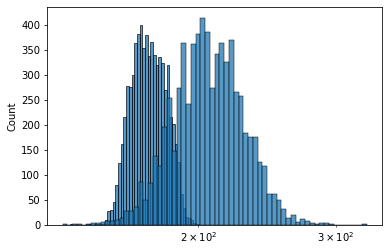

In [633]:
sns.histplot(y_pred, label='prediction', log_scale=True)
sns.histplot(y_train, label='target', log_scale=True)

In [634]:
def rmse (y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [635]:
rmse(y_train, y_pred)

39.22239720493296

In [636]:
y_pred_val = w_0 + X_val.dot(w)
rmse(y_val, y_pred_val)

40.1444841126739

## Feature Engineering

In [637]:
# Convert American odds to probabilities
def convert_american_odds_to_probabilities(american_odds):
    if american_odds >= 0:
        decimal_odds = (american_odds / 100) + 1
    else:
        decimal_odds = (100 / -american_odds) + 1
    implied_probability = 1 / decimal_odds
    return implied_probability

def adjust_probabilities_for_margin(probabilities):
    total_probability = sum(probabilities)
    adjusted_probabilities = [probability / total_probability for probability in probabilities]
    return adjusted_probabilities

In [638]:
# Apply conversion functions on multiple columns
columns_to_convert = ['Open_Odds_OU', 'Pinnacle_Odds_OU', '5dimes_Odds_OU', 'Heritage_Odds_OU', 'Bovada_Odds_OU', 'Betonline_Odds_OU', 'Best_Odds_OU', 'Worst_Odds_OU']

# Apply conversion functions to each column using apply() and lambda expressions
df_train[columns_to_convert] = df_train[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_train[columns_to_convert] = df_train[columns_to_convert].apply(adjust_probabilities_for_margin)

In [639]:
# Apply conversion functions to each column using apply() and lambda expressions
df_val[columns_to_convert] = df_val[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_val[columns_to_convert] = df_val[columns_to_convert].apply(adjust_probabilities_for_margin)

In [640]:
# Apply conversion functions to each column using apply() and lambda expressions
df_test[columns_to_convert] = df_test[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_test[columns_to_convert] = df_test[columns_to_convert].apply(adjust_probabilities_for_margin)

In [641]:
del df_train['Average_Odds_OU']
del df_val['Average_Odds_OU']
del df_test['Average_Odds_OU']


In [642]:
X_train2 = np.log1p(df_train.values) 
X_val2 = np.log1p(df_val.values)
X_test2 = np.log1p(df_test.values)

In [643]:
w_0 , w = train_linear_regression(X_train2, y_train)
y_pred2 = w_0 + X_train2.dot(w)

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

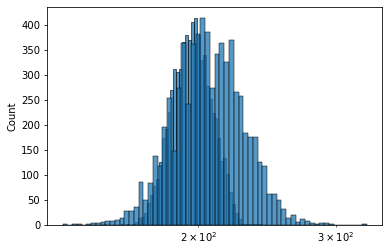

In [644]:
sns.histplot(y_pred2, label='prediction', log_scale=True)
sns.histplot(y_train, label='target', log_scale=True)

In [645]:
rmse(y_train, y_pred2)

20.851554556270198

### Adding a column for RMSE between each line column and the actual total

In [646]:
def rmse_dataset_columns (total, line_col):
    rmse_col = ((total - line_col) ** 2) ** .5
    return rmse_col

In [647]:
rmse_cols = [col for col in df_shuffled.columns if 'Line' in col]

In [648]:
for col in df_shuffled.columns:
    if col in rmse_cols:
        df_shuffled[col + '_RSE'] = rmse_dataset_columns(df_shuffled.Total, df_shuffled[col])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [649]:
df_shuffled

,away_team_id,home_team_id,game_id,PercentBet_OU,Open_Line_OU,Open_Odds_OU,Pinnacle_Line_OU,Pinnacle_Odds_OU,5dimes_Line_OU,5dimes_Odds_OU,...,Total,Open_Line_OU_RSE,Pinnacle_Line_OU_RSE,5dimes_Line_OU_RSE,Heritage_Line_OU_RSE,Bovada_Line_OU_RSE,Betonline_Line_OU_RSE,Average_Line_OU_RSE,Best_Line_OU_RSE,Worst_Line_OU_RSE
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-05,1610612760,1610612757,21700144,37.8,208.0,-110.0,212.0,-104.0,212.0,-107.0,...,202.0,6.0,10.0,10.0,10.0,10.0,9.0,9.17,10.0,6.0
2014-12-09,1610612748,1610612756,21400313,46.0,203.5,-110.0,202.5,-110.0,202.5,-105.0,...,200.0,3.5,2.5,2.5,2.5,3.0,2.5,2.75,3.5,2.5
2013-02-24,1610612758,1610612740,21200834,43.5,200.5,-110.0,204.5,-102.0,204.5,-110.0,...,205.0,4.5,0.5,0.5,0.0,0.0,0.5,1.00,0.0,4.5
2014-04-02,1610612749,1610612748,21301121,100.0,195.0,-110.0,194.0,-105.0,194.0,-105.0,...,173.0,22.0,21.0,21.0,21.0,22.0,21.5,21.42,22.0,21.0
2015-03-15,1610612737,1610612747,21400989,58.0,197.5,-110.0,194.5,-100.0,194.5,-103.0,...,177.0,20.5,17.5,17.5,17.5,18.0,18.0,18.17,20.5,17.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-03-25,1610612757,1610612760,21701100,41.2,212.0,-110.0,218.0,-105.0,218.0,-108.0,...,213.0,1.0,5.0,5.0,5.0,5.0,5.0,4.00,5.0,1.0
2018-10-24,1610612750,1610612761,21800055,43.4,226.0,-110.0,226.5,-109.0,227.0,-106.0,...,217.0,9.0,9.5,10.0,9.0,10.0,9.5,9.50,10.0,9.0
2013-01-05,1610612757,1610612750,21200494,100.0,192.5,-110.0,190.5,-105.0,190.5,-107.0,...,199.0,6.5,8.5,8.5,8.5,9.0,9.0,8.33,6.5,9.0


In [650]:
df_train3 = df_shuffled.iloc[:n_train].copy()
df_val3 = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test3 = df_shuffled.iloc[n_train+n_val:].copy()

In [651]:
y_train3 = df_train3.Total.values
y_val3 = df_val3.Total.values
y_test3 = df_test3.Total.values

In [652]:
del df_train3['Total']
del df_val3['Total']
del df_test3['Total']

In [653]:
df_train3 = df_train3.fillna(0)
df_val3 = df_val3.fillna(0)
df_test3 = df_test3.fillna(0)

In [654]:
# Apply conversion functions to each column using apply() and lambda expressions
df_train3[columns_to_convert] = df_train3[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_train3[columns_to_convert] = df_train3[columns_to_convert].apply(adjust_probabilities_for_margin)

In [655]:
# Apply conversion functions to each column using apply() and lambda expressions
df_val3[columns_to_convert] = df_val3[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_val3[columns_to_convert] = df_val3[columns_to_convert].apply(adjust_probabilities_for_margin)

In [656]:
# Apply conversion functions to each column using apply() and lambda expressions
df_test3[columns_to_convert] = df_test3[columns_to_convert].apply(lambda x: x.apply(convert_american_odds_to_probabilities))
df_test3[columns_to_convert] = df_test3[columns_to_convert].apply(adjust_probabilities_for_margin)

In [657]:
del df_train3['Average_Odds_OU']
del df_val3['Average_Odds_OU']
del df_test3['Average_Odds_OU']

In [658]:
X_train3 = np.log1p(df_train3.values) 
X_val3 = np.log1p(df_val3.values)
X_test3 = np.log1p(df_test3.values)

In [659]:
w_0 , w = train_linear_regression(X_train3, y_train)
y_pred3 = w_0 + X_train3.dot(w)

<AxesSubplot:ylabel='Count'>

<AxesSubplot:ylabel='Count'>

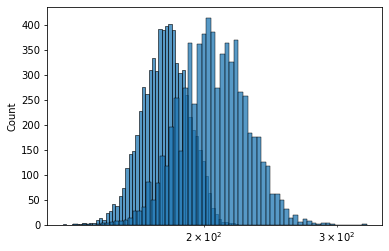

In [660]:
sns.histplot(y_pred3, label='prediction', log_scale=True)
sns.histplot(y_train, label='target', log_scale=True)

In [661]:
rmse(y_train, y_pred3)

33.81538006351521

In [667]:
y_actual = df_train.Average_Line_OU.values
y_best = df_train.Best_Line_OU.values
y_worst = df_train.Worst_Line_OU.values


In [668]:
print(rmse(y_train, y_actual))
print(rmse(y_train, y_best))
print(rmse(y_train, y_worst))

17.9193970429671
17.947851212915516
20.415447397650933


In [677]:
rmse(y_train, y_pred2)

20.851554556270198

## Our best prediction matches the bookies worst, with their best beating us by three points. Pretty close!